extracting average velocity from attack_data/sim_data/mules/104.csv


100%|██████████| 50904/50904 [00:56<00:00, 899.37it/s]


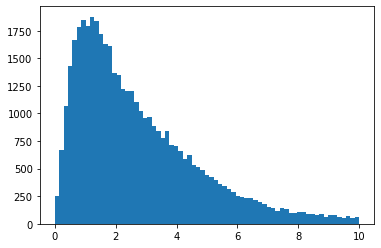

q25 1.237806200500825 q50 2.6679180081538103 q75 4.098029815806795

extracting average velocity from attack_data/sim_data/mules/135.csv


100%|██████████| 2566/2566 [00:02<00:00, 858.76it/s]


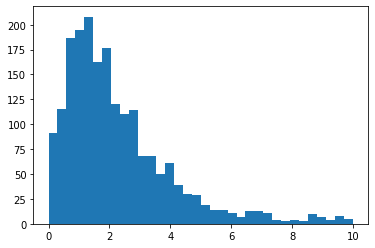

q25 1.1609195918676587 q50 2.6521098112191437 q75 4.143300030570629



In [115]:
# get the average velocity from the ground truth data

import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import pandas as pd
import numpy as np

SIMDATA_PATH="attack_data/sim_data/mules/"
GTDATA_PATH ="attack_data/ground_truth/"

def average_velocity_from_trace(trace_file, limit=10000000, downsample=100):
    
    print("extracting average velocity from", trace_file)
    
    # import file
    gateway_df = pd.read_csv(trace_file)

    # down sample to every 100
    gateway_df_smol = gateway_df[0:limit:downsample]
    gateway_df_smol.head()
    
    # filter to adjadent gateways with a time difference larger than 3 seconds
    diff_gateway_df = gateway_df_smol.diff()
    
    backbone_gateway_df = gateway_df_smol[diff_gateway_df['norm_secs (secs)'] > 3]
    backbone_gateway_df.head()

    # import the ground truth gateway location file
    gateway_positions_df = pd.read_csv(GTDATA_PATH + 'sensors.csv')

    velocities = []
    for i in tqdm(range(1, backbone_gateway_df.shape[0]), position=0, leave=True):

        src_gateway_id, dst_gateway_id = int(backbone_gateway_df.iloc[i-1]['sensor ID']), int(backbone_gateway_df.iloc[i]['sensor ID'])
        src_time_s, dst_time_s = float(backbone_gateway_df.iloc[i-1]['norm_secs (secs)']), float(backbone_gateway_df.iloc[i]['norm_secs (secs)'])

        src_gateway_x, src_gateway_y = gateway_positions_df.iloc[src_gateway_id]['x (m)'], gateway_positions_df.iloc[src_gateway_id]['y (m)']
        dst_gateway_x, dst_gateway_y = gateway_positions_df.iloc[dst_gateway_id]['x (m)'], gateway_positions_df.iloc[dst_gateway_id]['y (m)']

        distance = math.sqrt((src_gateway_x - dst_gateway_x)**2 + (src_gateway_y - dst_gateway_y)**2)
        if distance == 0 and src_gateway_id == dst_gateway_id:
            continue
#         if distance == 0:
#             continue
        velocities.append(
            distance / (dst_time_s - src_time_s)
        )

    _ = plt.hist(velocities, range=[0, 10], bins='auto')
    plt.show()

    q75, q25 = np.percentile(velocities, [75 ,25])
    iqr = q75 - q25

    print('q25', q25, 'q50', q25 + iqr/2, 'q75', q75)
    print()
    
    
average_velocity_from_trace(SIMDATA_PATH + "104.csv", limit=100000000)
average_velocity_from_trace(SIMDATA_PATH + "135.csv", limit=100000000)
